In [1]:
hbb = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"
pr39 = "METQRASLCLGRWSLWLLLLGLVVPSASAQALSYREAVLRAVDRLNEQSSEANLYRLLELDQPPKADEDPGTPKPVSFTVKETVCPRPTRQPPELCDFKENGRVKQCVGTVTLNPSIHSLDISCNEIQSVRRRPRPPYLPRPRPPPFFPPRLPPRIPPGFPPRFPPRFPGKR"

In [2]:
from disassembly.simulate_proteolysis import simulate_proteolysis, enzyme_set, enzyme

enzymes = enzyme_set(
    [
        enzyme({"K": 1}, "protease_iv"),
        enzyme({"K": 0.5, "R": 0.5}, "trypsin"),
        enzyme({"V": 0.5, "I": 0.25, "A": 0.15, "T": 0.1}, "elne"),
    ],
    [1, 1, 1], #activities
    [1, 1, 1], #abundances
)

print(enzymes.meta_enzyme)


sequence_dict, sequence_graph = simulate_proteolysis(
    pr39,
    n_start=1,
    n_generate=1000,
    endo_or_exo_probability=[0.5, 0.5],
    enzymes=enzymes,
)

{'V': 0.16666666666666666, 'I': 0.08333333333333333, 'L': 0.0, 'E': 0.0, 'Q': 0.0, 'D': 0.0, 'N': 0.0, 'H': 0.0, 'W': 0.0, 'F': 0.0, 'Y': 0.0, 'R': 0.16666666666666666, 'K': 0.5, 'S': 0.0, 'T': 0.03333333333333333, 'M': 0.0, 'A': 0.049999999999999996, 'G': 0.0, 'P': 0.0, 'C': 0.0}
 999 / 1000
330 unique peptides. 1001 total


0.5754452152492251


Text(0.5, 1.0, 'Real frequency for PR39')

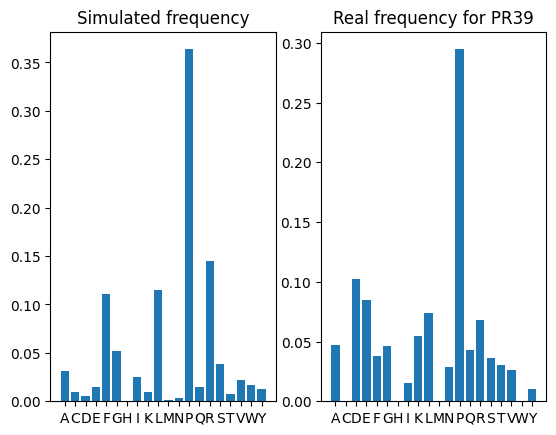

In [3]:
import matplotlib.pyplot as plt
from disassembly.simulate_proteolysis import amino_acids
def get_aminoacid_dist(sequence_dict):
    frequencies = {aa:0 for aa in amino_acids.values()}
    for sequence, copy_number in sequence_dict.items():
        for amino_acid in sequence:
            frequencies[amino_acid] += copy_number
    frequencies_sum = sum(frequencies.values())
    if frequencies_sum == 0:
        dist = {aa:0 for aa,f in frequencies.items()}
    else:
        dist = {aa:f/frequencies_sum for aa,f in frequencies.items()}
    dist = dict(sorted(dist.items()))
    return dist

import numpy as np
def KL(a, b):
    a = np.asarray(list(a)) + 1e-8
    b = np.asarray(list(b)) + 1e-8
    a = 1e-8 + a / np.sum(a)
    b = 1e-8 + b / np.sum(b)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

import pandas as pd

real_frequencies = pd.read_csv("../amino_acid_distribution.csv").sort_values("Unnamed: 0")
dist = get_aminoacid_dist(sequence_dict)
print(KL(dist.values(), real_frequencies["relative_frequency"].values))

fig, axs = plt.subplots(1,2)

axs[0].bar(x=list(dist.keys()), height=dist.values())
axs[1].bar(x=real_frequencies["Unnamed: 0"], height=real_frequencies["relative_frequency"])

axs[0].set_title("Simulated frequency")
axs[1].set_title("Real frequency for PR39")

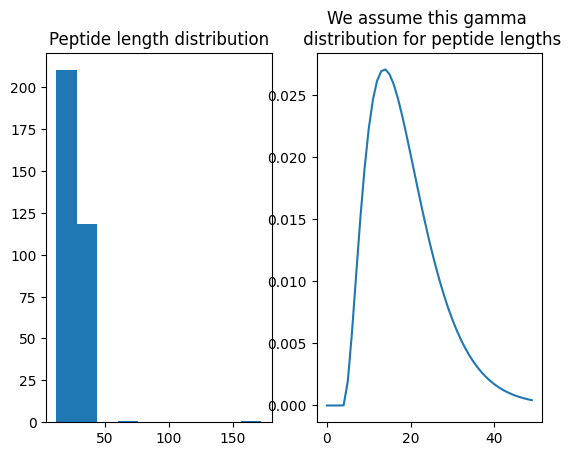

In [4]:
import numpy as np
from scipy.stats import gamma


fig, axs = plt.subplots(1,2)
axs[0].hist([len(s) for s in sequence_dict.keys()])
axs[0].set_title("Peptide length distribution")
a, shape, scale = 3, 8, 10  # mean = 8, sd = 2
g = gamma(a=a, scale=scale, loc=shape)
x = np.linspace(0, 100)
s = g.pdf(x)
axs[1].plot(s)

axs[1].set_title("We assume this gamma \n distribution for peptide lengths")
plt.show()

In [5]:
# This simulates the biological and mass. spec. "filtering"
sampled_sequence_dict = {}
sum_gamma = sum(s)
for sequence, copy_number in sequence_dict.items():
    sequence_length = len(sequence)
    a = g.pdf(sequence_length) / max(s)
    u = np.random.uniform(0, 1)
    kl_without_adding_sequence = KL(get_aminoacid_dist(sampled_sequence_dict).values(), real_frequencies["relative_frequency"].values)
    sampled_sequence_dict_copy = sampled_sequence_dict.copy()
    sampled_sequence_dict_copy[sequence] = copy_number
    kl_with_adding_sequence = KL(get_aminoacid_dist(sampled_sequence_dict_copy).values(), real_frequencies["relative_frequency"].values)
    if u < a and kl_with_adding_sequence < kl_without_adding_sequence:
        sampled_sequence_dict[sequence] = copy_number

In [6]:
print(sum(sampled_sequence_dict.values()), sum(sequence_dict.values()))

93 1001


Text(0.5, 0, 'Sequence length')

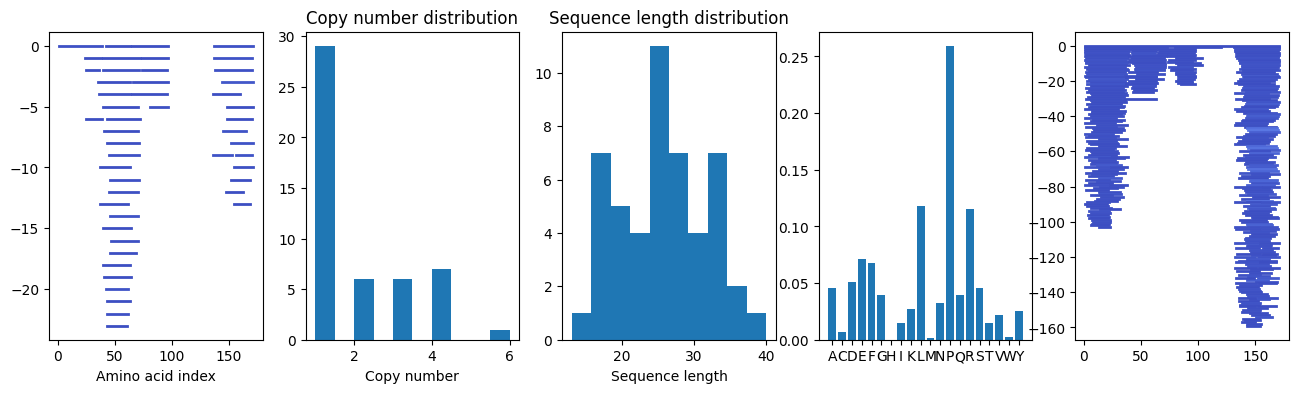

In [7]:
import numpy as np
import matplotlib
dist = get_aminoacid_dist(sampled_sequence_dict)
spaces = np.zeros(((len(sampled_sequence_dict.keys())), len(pr39)))

fig, ax = plt.subplots(1, 5, figsize=(16, 4))
i = 0
cmap = matplotlib.cm.coolwarm
sampled_sequence_dict = dict(
    sorted(sampled_sequence_dict.items(), key=lambda item: len(item[0]), reverse=True)
)
for sequence, copy_number in sampled_sequence_dict.items():
    start = pr39.find(sequence)
    end = start + len(sequence)
    for height in range(spaces.shape[0]):
        position = spaces[height, start:end]
        if sum(position) == 0:
            spaces[height, start:end] = 1
            ax[0].plot(
                [start + 1, end - 1],
                [-height, -height],
                linewidth=2,
                color=cmap(copy_number),
            )
            break
sequence_dict = dict(
    sorted(sequence_dict.items(), key=lambda item: len(item[0]), reverse=True)
)
spaces = np.zeros(((len(sequence_dict.keys())), len(pr39)))
for sequence, copy_number in sequence_dict.items():
    start = pr39.find(sequence)
    end = start + len(sequence)
    for height in range(spaces.shape[0]):
        position = spaces[height, start:end]
        if sum(position) == 0:
            spaces[height, start:end] = 1
            ax[4].plot(
                [start + 1, end - 1],
                [-height, -height],
                linewidth=2,
                color=cmap(copy_number),
            )
            break
ax[1].hist(sampled_sequence_dict.values())
ax[3].bar(x=list(dist.keys()),height=dist.values())
ax[1].set_title("Copy number distribution")
ax[0].set_xlabel("Amino acid index")
ax[1].set_xlabel("Copy number")
ax[2].hist([len(s) for s in sampled_sequence_dict.keys()])
ax[2].set_title("Sequence length distribution")
ax[2].set_xlabel("Sequence length")
